<div style="text-align: center;">

# From scattered data to gridded products

## [Tutorial at Transform 2020](https://sched.co/c7KE) 💚

<img src="https://github.com/fatiando/verde/raw/c77c7d84aa361fb1209ae38f7d6a05253a4518fc/doc/_static/readme-banner.png" style="width: 70%">

### A hands-on tour of Verde, a Python package for processing and gridding geophysical/geospatial data with a twist of machine learning.
    
</div>

<br>

**Instructors:**
[Leonardo Uieda](https://www.leouieda.com/)<sup>1</sup> and
[Santiago Soler](https://santisoler.github.io/)<sup>2,3</sup>

<sup>1</sup>University of Liverpool, UK |
<sup>2</sup>CONICET, Argentina | 
<sup>3</sup>Universidad Nacional de San Juan, Argentina

## Useful links

* Live stream: https://youtu.be/-xZdNdvzm3E
* Workshop material: https://github.com/fatiando/transform2020 
* Verde documentation | https://www.fatiando.org/verde

## Contents

1. [Loading data](#load)
1. [Projections](#projections)
1. [Trends](#trends)
1. [Blocked reductions](#reduction)
1. [Gridding with splines](#gridding)
1. [Chainning operations](#chain)
1. [Training and validation split](#train-test-split)
1. [Cross-validation](#cv)
1. [Hyper-parameter optimization](#splinecv)

## Importing libraries

The first thing we'll do is import all of the libraries that we need:

In [3]:
import verde as vd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
import pyproj
import pooch

In [4]:
plt.rcParams["figure.dpi"] = 120
#%config InlineBackend.figure_format = 'retina'

<a id="load"></a>

## Loading data

In [36]:
fname = pooch.retrieve(
    "https://raw.githubusercontent.com/fatiando/transform2020/master/data/ew9105.m77t", 
    known_hash=None,
)

In [103]:
data = pd.read_csv(fname, sep="\t")
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
1,EW9105,0,19910804,100.0,-27.46815,-79.68756,3,NaN,5.401,4046.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EW9105,0,19910804,101.0,-27.46627,-79.69027,3,NaN,5.405,4049.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EW9105,0,19910804,102.0,-27.46439,-79.69298,3,NaN,5.401,4046.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EW9105,0,19910804,103.0,-27.46251,-79.69571,3,NaN,5.406,4050.0,...,NaN,NaN,NaN,NaN,NaN,NaN,21.8,NaN,NaN,NaN
5,EW9105,0,19910804,104.0,-27.46061,-79.69845,3,NaN,5.407,4050.0,...,NaN,NaN,NaN,NaN,NaN,NaN,21.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63535,EW9105,0,19910917,204.0,-21.82675,-108.74021,3,NaN,4.962,3714.0,...,NaN,NaN,NaN,NaN,NaN,NaN,21.6,NaN,NaN,NaN
63536,EW9105,0,19910917,205.0,-21.82975,-108.74036,3,NaN,4.965,3716.0,...,NaN,NaN,NaN,NaN,NaN,NaN,20.8,NaN,NaN,NaN
63537,EW9105,0,19910917,206.0,-21.83275,-108.74051,3,NaN,4.959,3711.0,...,NaN,NaN,NaN,NaN,NaN,NaN,21.6,NaN,NaN,NaN
63538,EW9105,0,19910917,207.0,-21.83576,-108.74066,3,NaN,4.961,3713.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


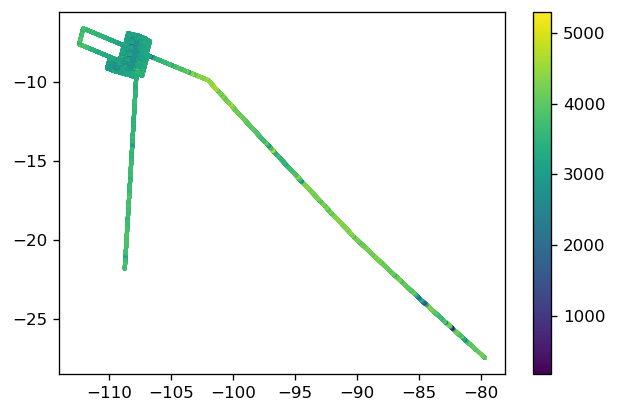

In [104]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

In [105]:
data = data[vd.inside((data.LON, data.LAT), [-110, -107, -9.5, -5])].dropna(subset=["CORR_DEPTH"])
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
10417,EW9105,0,19910811,624.0,-8.28569,-107.00034,3,NaN,4.413,3298.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9.5,NaN,NaN,NaN
10418,EW9105,0,19910811,625.0,-8.28484,-107.00307,3,NaN,4.512,3373.0,...,NaN,NaN,NaN,NaN,NaN,NaN,11.7,NaN,NaN,NaN
10419,EW9105,0,19910811,626.0,-8.28398,-107.00578,3,NaN,4.518,3377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,12.8,NaN,NaN,NaN
10420,EW9105,0,19910811,627.0,-8.28314,-107.00850,3,NaN,4.526,3383.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13.4,NaN,NaN,NaN
10421,EW9105,0,19910811,628.0,-8.28230,-107.01122,3,NaN,4.447,3324.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59456,EW9105,0,19910914,613.0,-9.48615,-107.79604,3,NaN,4.662,3486.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59457,EW9105,0,19910914,614.0,-9.48906,-107.79695,3,NaN,4.678,3499.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59458,EW9105,0,19910914,615.0,-9.49194,-107.79783,3,NaN,4.677,3498.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59459,EW9105,0,19910914,616.0,-9.49483,-107.79870,3,NaN,4.681,3501.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


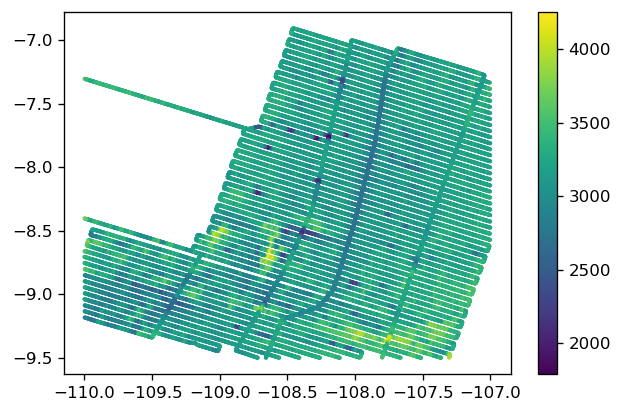

In [106]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

<a id="projections"></a>

## Projections

In [107]:
projection = pyproj.Proj(proj="merc", lat_ts=data.LAT.mean())

In [108]:
coordinates = projection(data.LON.values, data.LAT.values)

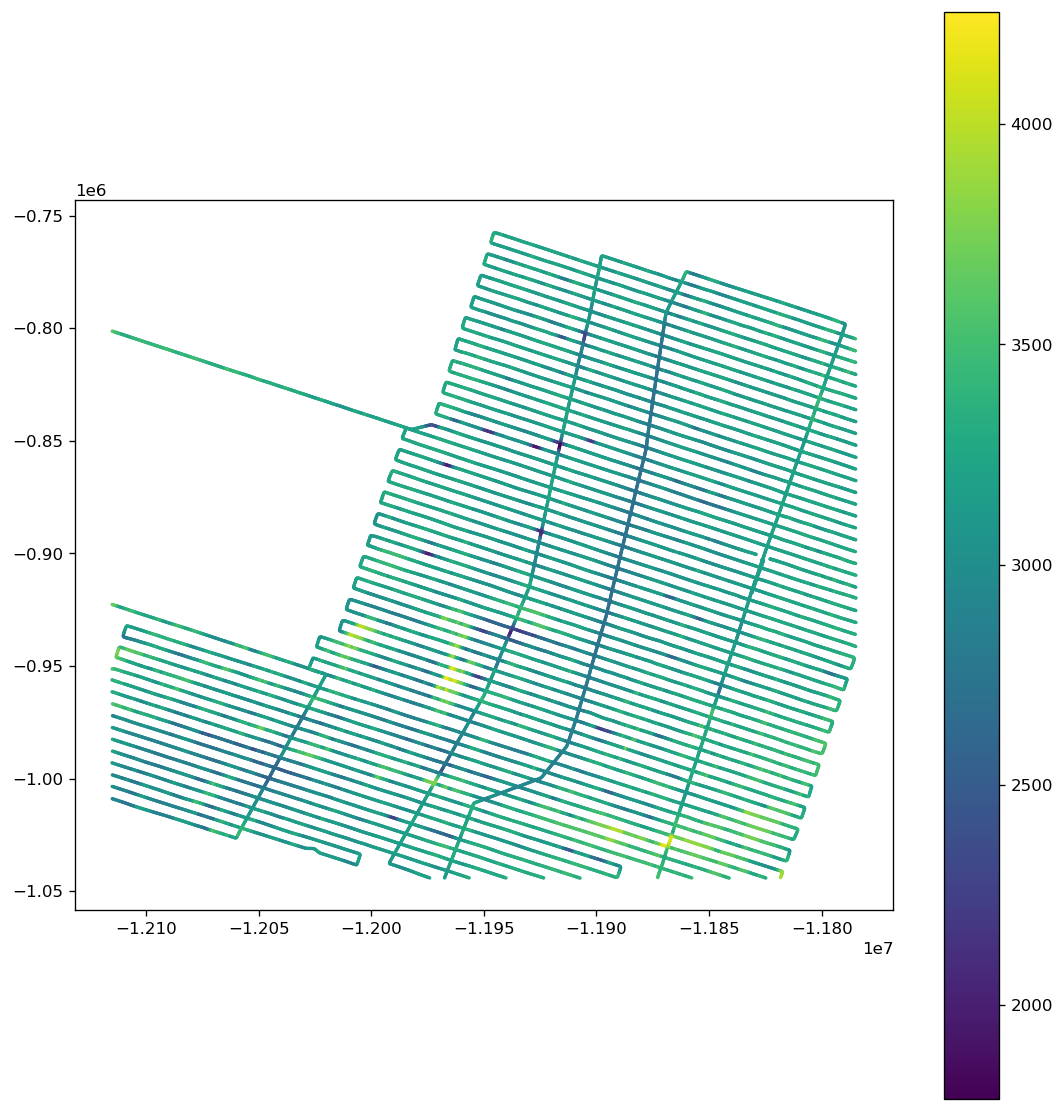

In [109]:
plt.figure(figsize=(11, 12))
plt.scatter(coordinates[0], coordinates[1], c=data.CORR_DEPTH, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="reduction"></a>

## Blocked reductions

In [110]:
reducer = vd.BlockReduce(np.median, spacing=5000)
block_coords, block_bathymetry = reducer.filter(coordinates, data.CORR_DEPTH)

In [111]:
data.shape

(44376, 26)

In [112]:
block_bathymetry.shape

(2620,)

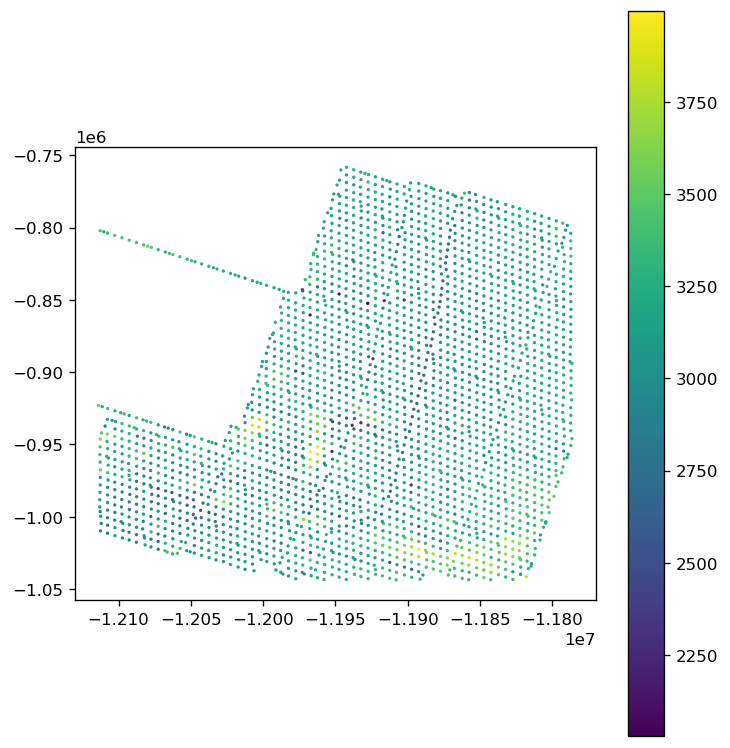

In [113]:
plt.figure(figsize=(7, 8))
plt.scatter(block_coords[0], block_coords[1], c=block_bathymetry, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="gridding"></a>

## Gridding with splines

In [114]:
spline = vd.Spline()
spline.fit(block_coords, block_bathymetry)

Spline()

In [115]:
predicted = spline.predict(coordinates)
residuals = data.CORR_DEPTH - predicted

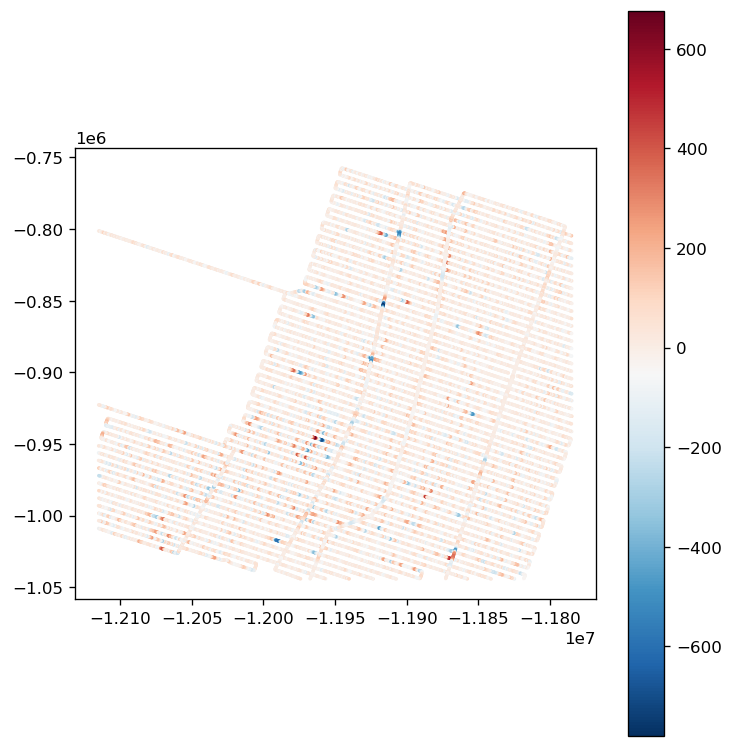

In [116]:
plt.figure(figsize=(7, 8))
plt.scatter(coordinates[0], coordinates[1], c=residuals, s=1, cmap="RdBu_r")
plt.axis("scaled")
plt.colorbar()

In [117]:
grid_coords = vd.grid_coordinates(vd.get_region(coordinates), spacing=2000)

In [118]:
grid_bathymetry = spline.predict(grid_coords)

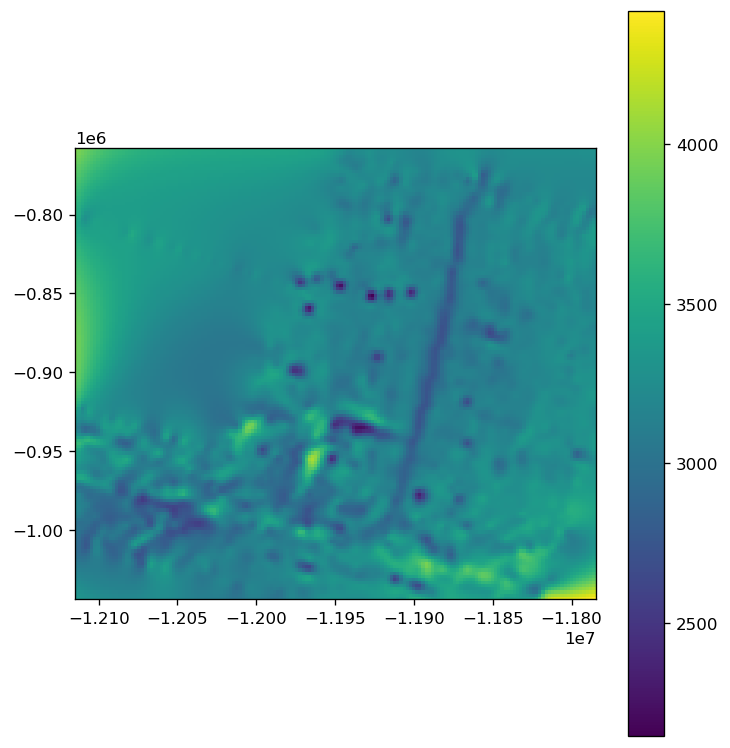

In [119]:
plt.figure(figsize=(7, 8))
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_bathymetry)
plt.axis("scaled")
plt.colorbar()

In [201]:
grid = spline.grid(spacing=2000)

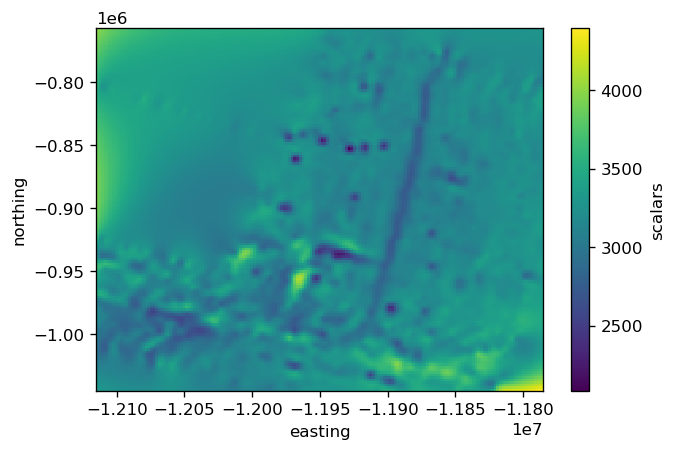

In [202]:
grid.scalars.plot()

In [203]:
grid = vd.distance_mask(coordinates, maxdist=10e3, grid=grid)

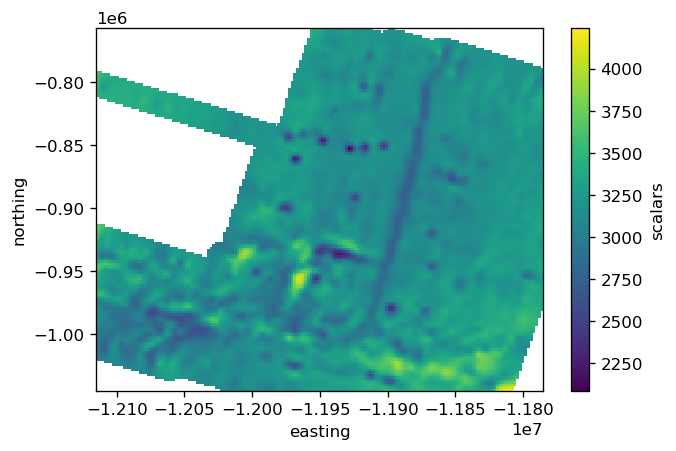

In [204]:
grid.scalars.plot()

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# ☕ Break (20 min)
    
</div>

<a id="chain"></a>

## Chainning operations

In [205]:
chain = vd.Chain([
    ("reduce", vd.BlockReduce(np.median, spacing=5000)),
    ("spline", vd.Spline()),
])
chain

Chain(steps=[('reduce',
              BlockReduce(reduction=<function median at 0x7fadf4f25ea0>,
                          spacing=5000)),
             ('spline', Spline())])

In [206]:
chain.fit(coordinates, data.CORR_DEPTH)

Chain(steps=[('reduce',
              BlockReduce(reduction=<function median at 0x7fadf4f25ea0>,
                          spacing=5000)),
             ('spline', Spline())])

In [207]:
grid = chain.grid(spacing=2000)

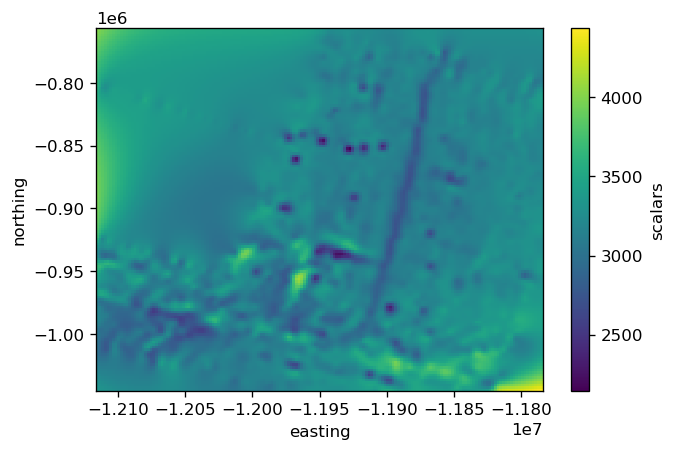

In [208]:
grid.scalars.plot()

<a id="train-test-split"></a>

## Training and validation split

In [226]:
train, test = vd.train_test_split(coordinates, data.CORR_DEPTH, spacing=10e3, random_state=0, test_size=0.1)

In [227]:
train

((array([-11784785.2164437 , -11785085.89271857, -11785384.36623684, ...,
         -11872619.03418915, -11872714.85410092, -11872802.96436462]),
  array([ -909677.28127517,  -909583.296975  ,  -909488.20718652, ...,
         -1043269.78931534, -1043590.40536917, -1043904.36768959])),
 (array([3298., 3373., 3377., ..., 3498., 3501., 3513.]),),
 (None,))

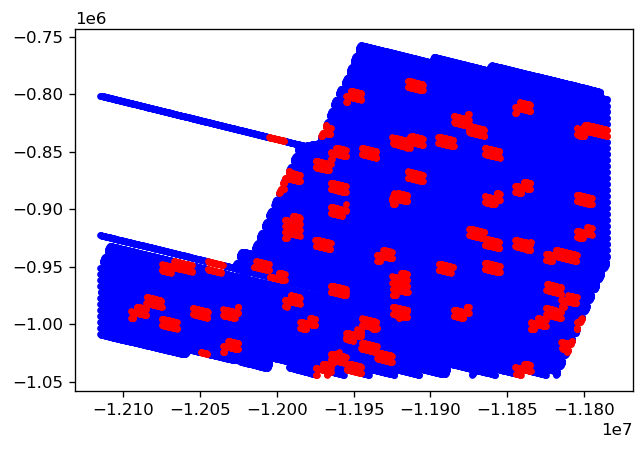

In [228]:
plt.plot(train[0][0], train[0][1], ".b")
plt.plot(test[0][0], test[0][1], ".r")

In [229]:
chain.fit(*train)

Chain(steps=[('reduce',
              BlockReduce(reduction=<function median at 0x7fadf4f25ea0>,
                          spacing=5000)),
             ('spline', Spline())])

In [230]:
chain.score(*test)

0.4726998314763038

<a id="cv"></a>

## Cross-validation

In [235]:
cv = vd.BlockKFold(spacing=10e3, n_splits=5, shuffle=True, random_state=0)
scores = vd.cross_val_score(chain, coordinates, data.CORR_DEPTH, cv=cv)

(array([1., 2., 0., 2.]),
 array([0.39022824, 0.42738345, 0.46453865, 0.50169386, 0.53884907]),
 <a list of 4 Patch objects>)

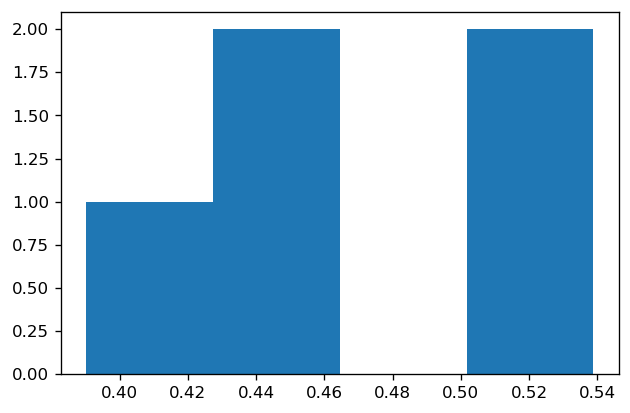

In [232]:
plt.hist(scores, bins="auto")

In [233]:
scores = vd.cross_val_score(chain, coordinates, data.CORR_DEPTH, cv=vd.BlockKFold(spacing=10e3, n_splits=5, shuffle=True), delayed=True)

In [234]:
scores = dask.compute(*scores)

<a id="splinecv"></a>

## Hyper-parameter optimization

In [160]:
chain = vd.Chain([
    ("reduce", vd.BlockReduce(np.median, spacing=5000)),
    ("spline", vd.Spline(damping=1e-5, mindist=10e3)),
])

In [236]:
scores = vd.cross_val_score(chain, coordinates, data.CORR_DEPTH, cv=cv)

(array([1., 2., 0., 2.]),
 array([0.39022824, 0.42738345, 0.46453865, 0.50169386, 0.53884907]),
 <a list of 4 Patch objects>)

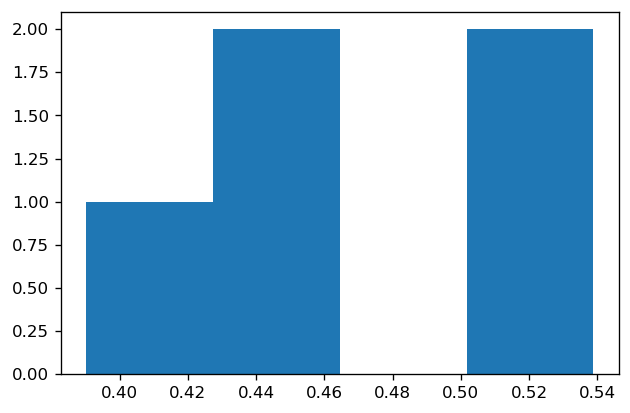

In [237]:
plt.hist(scores, bins="auto")

In [238]:
chain = vd.Chain([
    ("reduce", vd.BlockReduce(np.median, spacing=5000)),
    ("spline", vd.SplineCV(
        dampings=[1e-8, 1e-5], mindists=[5e3, 10e3, 15e3], cv=cv, delayed=True)
    ),
])

In [239]:
chain.fit(*train)
chain.score(*test)

0.4917379462469056

In [240]:
chain.named_steps["spline"].damping_

1e-08

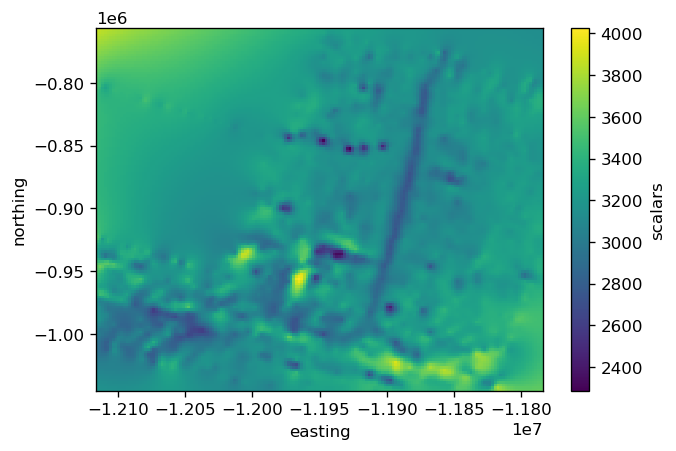

In [242]:
chain.grid(spacing=2000).scalars.plot()

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# Wrap up and work on your own data
    
</div>

## License

All code and text in this notebook is free software: you can redistribute it and/or
modify it under the terms of the BSD 3-clause License.
A copy of this license is provided in [LICENSE](https://github.com/fatiando/transform2020/blob/master/LICENSE).